In [41]:
# Deep understanding of what a derviative is -:
"""
rate of change of a function wrt its independent variable. 
It provides a deep understanding of how a function behaves, describing how a small change in the input variable affects the function's output
slope represents the best linear approxmiation of function behaviour near that point.

h = small change, a = original value. If you slightly change a, how does the function respond? Does the function go up or down and by how much? (Slope)
f'(x) = [f(x+h) - f(x)] / h where lim h -> 0 (Direction also matters, f'(x) > 0 : Function is increasing, f'(x) = 0 : Function minima or maxima)

second derivatives represent rate of change of the derivative itself.
"""

import math
import numpy as np
import matplotlib.pyplot as plt

In [42]:
# Scalar value function
def f(x):
    return 3*x ** 2 - 4*x + 5 # f(x) = 3x^2 - 4x + 5 (Parabola)

In [43]:
f(3.0)

20.0

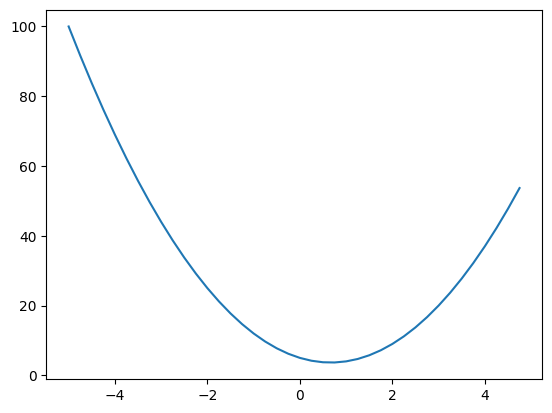

In [44]:
xs = np.arange(-5, 5, 0.25) 
ys = f(xs)
plt.plot(xs, ys) # Para

In [45]:
# Derivatives at different point of functions : f'(x) = 6x - 4
h = 0.000000000001
x = 3.0
f(x + h) # how much function changed
f(x + h) - f(x) # how function responded based on original value (positive change)
(f(x + h) - f(x)) / h # normalise to get slope 
# Answer is 14, if you put x = 3 in f'(x) = 6*3 - 4 = 14 so it is accurate. Calculus works!

14.001244608152774

In [46]:
# More derivatives
a = 2.0
b = -3.0
c = 10.0
d = a*b + c # 3 scalars
print(d)

4.0


In [47]:
h = 0.0001

# Inputs
a = 2.0
b = -3.0
c = 10.0


d1 = a * b + c  
# look at derivative of d wrt a
a += h
d2 = a * b + c  
print(f'd1 = {d1}') # 4
print(f'd2 = {d2}') # 3.99 : went down so slope will be negative
print(f'slope of d wrt a = {(d2 - d1) / h}') # d2-d1 : how much the function increased, bumping up the normal input by tiny amount which is normalised by h : slope

# look at derivatives of d wrt a

d1 = a * b + c  
b += h
d2 = a * b + c  
print(f'slope of d wrt b = {(d2 - d1) / h}') 

d1 = 4.0
d2 = 3.999699999999999
slope of d wrt a = -3.000000000010772
slope of d wrt b = 2.0001000000124947


In [48]:
# Nobody does calculus like this in Neural Networks, we need data structures to handle these complex values
# Need to keep track of the graph : children and parent nodes 
# Need to keep track of children and what operation creates a particular value

class Value:
    """ Takes in scalar value and wraps it (like Tensor) """
    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data 
        self.grad = 0.0 # every value doesn't affect the output (L loss fn) 
        # How to do this automatically? 
        self._backward = lambda: None # fn which applies chain rule to gradients.
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        # Key take aways from manual : local derivative * global derivative [out.grad] (derivative of findal output of function wrt out data)
        # local derivative of self in addition = 1.0 * out.grad, other = 1.0 * out_grad
        other = other if isinstance(other, Value) else Value(other) # children of this value will be a, b which are children of (a + b) variable
        out = Value(self.data + other.data, (self, other), '+')
    
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')  # Record the operation as '*'

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other): # other + self
        return self + other

    def tanh(self):
        """ Implement tanh activation function """
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh') # only one child : self
    
        def _backward():
            self.grad += (1 - t)**2 * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad 
        out._backward = _backward
    
        return out
    
    def backward(self):
        """ Building topological graph to apply chain rule via ._backward on all nodes (storing them in set) and self.grad for final output = 1"""
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e' # using the +, python will automatically do a.__add__(b) which is self.data (a) + other.data(b) = a + b
d = e + c; d.label = 'd'
# data = -6 (a*b) , value = 10 
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L # -8

Value(data=-8.0)

In [50]:
# d._prev 
# d._op # +
# e._op # *

In [51]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [52]:
# Forward Pass
# draw_dot(L) # L being the root node

In [53]:
# Backpropagation : Start at end from L, reverse and calculate gradient for every single value
"""
for every single value -> compute derivative of that node with respect to L. 
Derivative of L wrt L = 1
Derivative of L wrt f, d, c, b, a etc... 

L = loss function
a,b,c,d,f = weights of neural network

How are these weights impacting the loss function. 
Hence backpropagation is very important.

grad = derivative of the output wrt to (this) some value.

As you can see grad is init 0, now we're going to fill up all grad values (do backward pass)

Opposite -:
If I change L with tiny amount of h, how much does L change?
"""


"\nfor every single value -> compute derivative of that node with respect to L. \nDerivative of L wrt L = 1\nDerivative of L wrt f, d, c, b, a etc... \n\nL = loss function\na,b,c,d,f = weights of neural network\n\nHow are these weights impacting the loss function. \nHence backpropagation is very important.\n\ngrad = derivative of the output wrt to (this) some value.\n\nAs you can see grad is init 0, now we're going to fill up all grad values (do backward pass)\n\nOpposite -:\nIf I change L with tiny amount of h, how much does L change?\n"

In [54]:
# Manual Backpropagation (Comuting Derivatives) : check graph, setting gradients

L.grad = 1.0 # manual backpropagation since dL/dL = 1

L = d * f
# dL/dd = ? f

# proof
# (f(x+h) - f(x))/h  
# increasing d/h : ((d+h)*f - d*f))/h = f

# so f.grad = derivative of L wrt f = d (4) as seen on graph
f.grad = 4.0 
d.grad = -2  # f (as derived above)

# Need to derive dL/dc (since rest is done) and dL/de
# How is L sensitive to c (if we change c how does it impact L, we know dL/dd and dd/dc)
# Impact of c is having on d and impact of d having on L then we can figure out how c impacts L.

# dd / dc ? 1.0 since derivate of c + e wrt c is just 1 
d = c + e

# We know how L impacts d and how c and e impacts d so dL/dc ? CHAIN RULE!
# chain rule : derivative of outside function leaving inside alone * derivative of inside function.
# (3x+1)^7 = 7x^6 * 3 where x = 3x+1 so : 21(3x+1)^6

# so dz/dx = dz/dy * dy/dx where we know both these things.

# Chain Rule

# WANT:
# dL / dc = (dL / dd) * (dd / dc)

# KNOW: 
# dL / dd (-2)
# dd / dc (1)
# so it's just dL/dd = -2. same for e.grad
# dL / de = -2

c.grad = -2.0 
e.grad = -2.0

# Recurse more, one more layer.
# dL / da = (dL / de) * (de / da)
# what is de / da, e = a * b so diffrentiation wrt a gives us b = -3
# dL/da = -2 * -3 = 6
a.grad = 6
b.grad = -2 * 2 # de/db = a = 2.0

# BP : Recursive application of chain rule


In [55]:
def test():
    h = 0.001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data 

    # Derivative of L wrt a
    # If we change L by h that'll just be derivative of L wrt L which is obviously 1. 

    print((L2 - L1) /h) # slope wrt x (can be any input nodes : a,b,c,L..)

test()

6.000000000000227


In [56]:
# Nudge in direction of gradient : L will go up, less negative (it was -8)
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


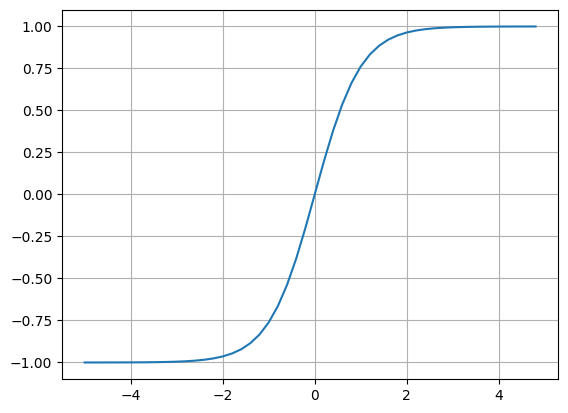

In [19]:
# Perceptron equation : sum(wi * xi) + bias = Insert in activation function = Output
# Activation function can be sigmoid, tanh etc..
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();
# -1 to 1 tanh function

In [57]:
# Perceptron Equation (Writing an activation function)
# weights = strengths of each input, inputs = x, bias = error
# inputs x1,x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights w1,w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label = 'x1*w1 + x2*w2'
n = x1w1_x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


In [58]:
# Perform backpropagation on the above image^ (all gradients 0 now)
o.grad = 1.0 # dO/dO = 1

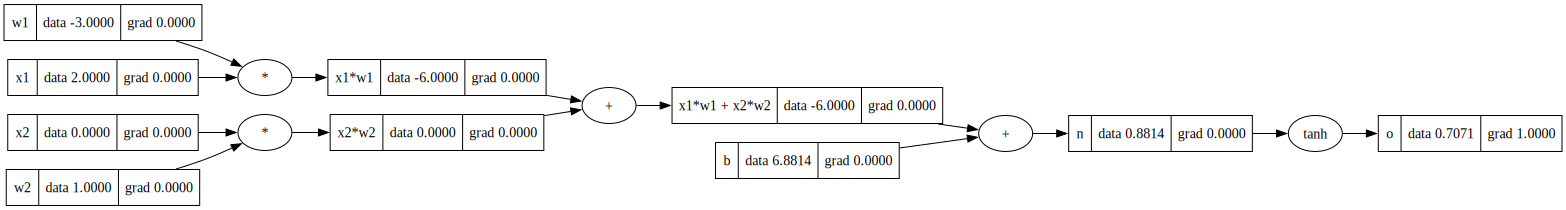

In [59]:
draw_dot(o) # basically apply perceptron equation and insert into an actiavtion function.

In [23]:
o.backward()
# o.grad = 1.0

In [25]:
o._backward()
n._backward()
b._backward()
x1w1_x2w2._backward()
x2w2._backward()
x1w1._backward()


In [27]:
1-o.data**2

0.4999999999999999

In [28]:
# Now need to backpropagate through tanh
# o = tanh(n)
# do/dn = 1 - tanh(n)**2
# do/dn = 1 - o**2 (0.5) 
# do/dn = .5
n.grad = 0.5
# From above rules we know, + = operator flow so both b and x1w1x2w2 will be same as n. 0.5
x1w1_x2w2.grad = 0.5
b.grad = 0.5
# Same for before, + operator
x1w1.grad = 0.5
x2w2.grad = 0.5
# For multiply operator on self = other.data * output_grad.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [29]:
# How to do this automatically? 
# Key take aways from manual : local derivative * global derivative [out.grad] (derivative of findal output of function wrt out data)
# local derivative of self in addition = 1.0 * out.grad, other = 1.0 * out_grad

In [60]:
# Do the same in PyTorch
# Pytorch by default doesn't requite gradients
import torch
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [80]:
import random
# Neural network model  
# MLP : Multi Layer Perceptron
# Every NN has inp layer -> hidden layers -> out layer (layers consist of bunch of Neutrons)
# Structure will take : input, weight[-1 to 1], bias[happiness] : wx+b

class Neuron:
    """ call function : forward pass """
    def __init__(self, n_in) -> None:
        self.w = [Value(random.uniform(-1, 1)) for _ in range(n_in)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x): # wx + b (weight * x(inp) + bias)
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) # perceptron formula
        out = act.tanh() # pass through activation function
        return out
    
    def parameters(self):
        return self.w + [self.b] # return weight and bias for each neuron if requested (PyTorch like)

class Layer:
    """ Consists of inp (n_in), out (n_out), hidden """
    def __init__(self, n_in, n_out) -> None:
        self.neurons = [Neuron(n_in) for _ in range(n_out)]

    def __call__(self, x): # apply formula for every neuron
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs # don't return a list if only one value
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, n_in, n_outs_list) -> None: # n_outs_list defines size of all input layers in NLP
        size = [n_in] + n_outs_list
        self.layers = [Layer(size[i], size[i + 1]) for i in range(len(n_outs_list))] # passes inp and out for multiple layers
    
    def __call__(self, x):
        for layer in self.layers:
            # Output of one layer becomes input to the next layer.
            x = layer(x) # apply perceptron formual to that that layer and update it's value for all inputs. Final value of x is returned
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [81]:
x = [2.0, 3.0, -1.0]
# n = Neuron(2)
# n = Layer(2, 3)
n = MLP(3, [4, 4, 1]) # 3D layers of inp, 2 layers of input(4, 4), 1 output(1)
n(x)

Value(data=-0.5918313325453538)

In [65]:
len(n.parameters())

41

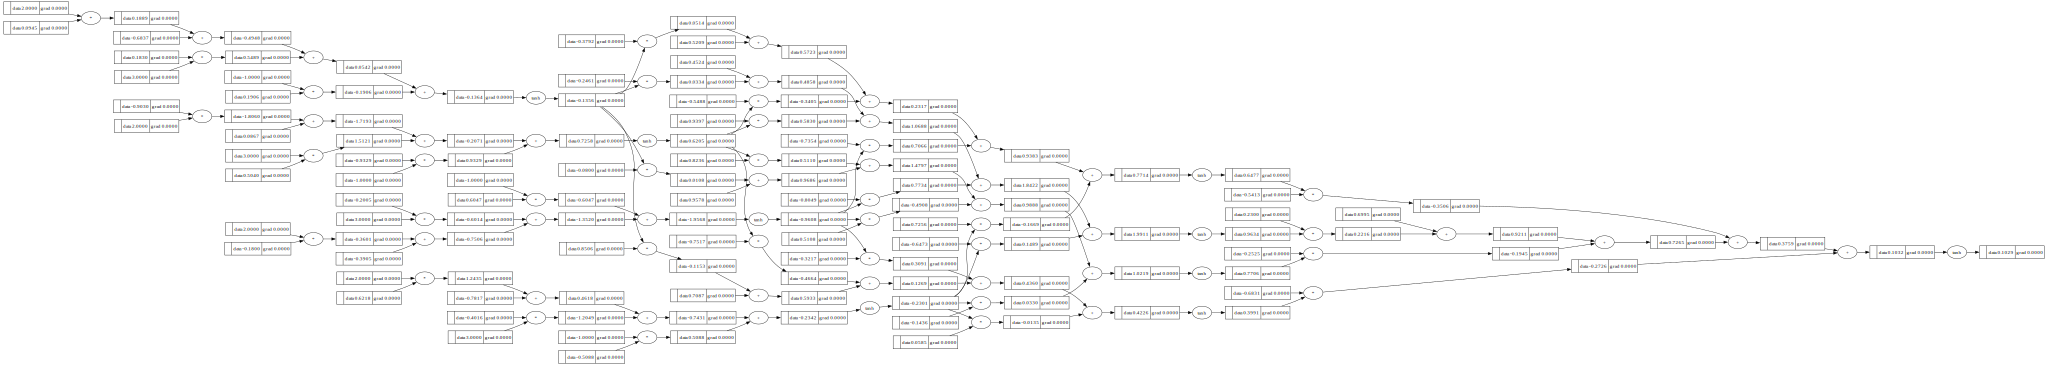

In [66]:
draw_dot(n(x)) # backpropagate automatically now (MLP)

In [83]:
# Binary Classifier Neural Network
# input
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

# desired output
ys = [1.0, -1.0, -1.0, 1.0] 

ypred = [n(x) for x in xs]

ypred # the answers are not correct. how to fine tune? minimise loss.
# type(ypred)

[Value(data=-0.5918313325453538),
 Value(data=-0.37080804418732005),
 Value(data=0.0547410107353394),
 Value(data=-0.6554027100237768)]

In [89]:
loss = sum((y_out - y_true)**2 for y_true, y_out in zip(ys, ypred)) # subtracting losses and squaring them {MSE}

# when y_out = y_true the expression output would be 0 (ideal)
# Some error here because of __radd__ : no fix found for now

TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

In [87]:
# Minimise Loss : diffrentiate (minima)
# loss.backward() # this does reverse chain rule (grad desc) on loss function which minimises it 

# Now weight of every neuron in the layer ALSO has a grad property attached to it (due to back pass) :: Now we can check by how much to increase/decrease weight for minimum loss
# n.layers[0].neurons[0].w[0].data

In [ ]:
# How to optimize (Calculate loss function -> Change neuron data by tiny amount (step size) -> Calculate loss function again -> Minimise)
# Do forward pass -> backward pass -> updating parameters -> forward parameter -> ...
for k in range(20):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0 # performing zero grad before back pass (MOST IMPORTANT RULE IN NEURAL NETWORK : pls .zero_grad() before .backward()) {reset}
  loss.backward()
  
  # update
  for p in n.parameters():
    learning_rate = -0.1
    p.data += learning_rate * p.grad # -0.1 = step size (Why negative, need to minimise loss, go in the opposite direction.) {learning rate}
  
  print(k, loss.data) # after 20 iterations, loss should be min + all xs == ys